# Machine Learning Project 
## Step 1
## Middle Eastern Portfolio (Tadawul All Share Index – TASI)

**General Research Question:**  
> **Do Middle Eastern investment portfolios demonstrate greater financial resilience compared to European portfolios when facing global market fluctuations?**

**Context:**  
In this first stage, we focus on analyzing a **Middle Eastern investment portfolio**, represented by the **Tadawul All Share Index (TASI)** from Saudi Arabia.

The goals of this stage are:
1. Perform descriptive data analysis  
2. Apply necessary preprocessing  
3. Formalize the learning problem  
4. Implement a simple baseline model (Linear Regression)

The European portfolio analysis (e.g., CAC40 or DAX) will follow in the next stage using the same methodology.


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Load the dataset ===
path = r"C:\Users\syeri\OneDrive\Bureau\ESILV\A4\S7\Machine learning\Project\Tadawul All Share Historical Data.csv"
df = pd.read_csv(path)

# Clean column headers
df.columns = df.columns.str.strip()
print("Columns detected:", list(df.columns))

# Rename columns to simpler names
rename_map = {'Vol.': 'Volume', 'Change %': 'Change'}
df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})

# Convert date column
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Convert numeric columns
for col in ['Price','Open','High','Low']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(',', '', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert Volume (e.g., "364.10M" → 364100000)
def convert_volume(v):
    if pd.isna(v): 
        return np.nan
    s = str(v).replace(',', '').strip()
    if s.endswith('M'):
        return float(s[:-1]) * 1e6
    if s.endswith('K'):
        return float(s[:-1]) * 1e3
    try:
        return float(s)
    except:
        return np.nan

if 'Volume' in df.columns:
    df['Volume'] = df['Volume'].apply(convert_volume)

# Convert percentage change
if 'Change' in df.columns:
    df['Change'] = df['Change'].astype(str).str.replace('%','', regex=False)
    df['Change'] = pd.to_numeric(df['Change'], errors='coerce')

# Sort chronologically and drop missing values
df = df.sort_values('Date').dropna(subset=['Date','Price'])
print(df.tail(3))


Columns detected: ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
        Date     Price      Open      High       Low       Volume  Change
2 2025-10-21  11545.80  11664.92  11665.77  11539.43  232780000.0   -0.85
1 2025-10-22  11585.90  11542.22  11618.28  11492.03  244610000.0    0.35
0 2025-10-23  11611.68  11599.57  11614.02  11549.23  226170000.0    0.22


## 1. Descriptive Analysis of the Data

This section explores the behavior of the Middle Eastern portfolio through:
- Price evolution over time  
- Distribution of daily returns  
- Rolling volatility (30 days)  
- Maximum drawdown  

These indicators will later help compare the resilience of Middle Eastern and European portfolios.


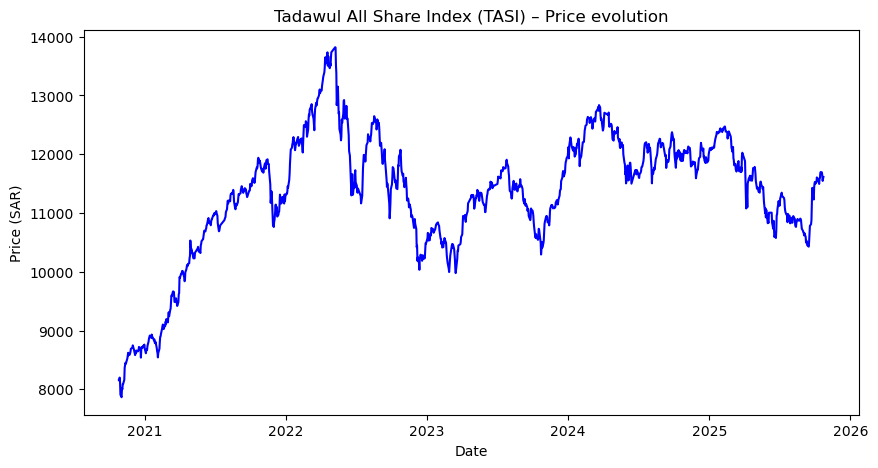

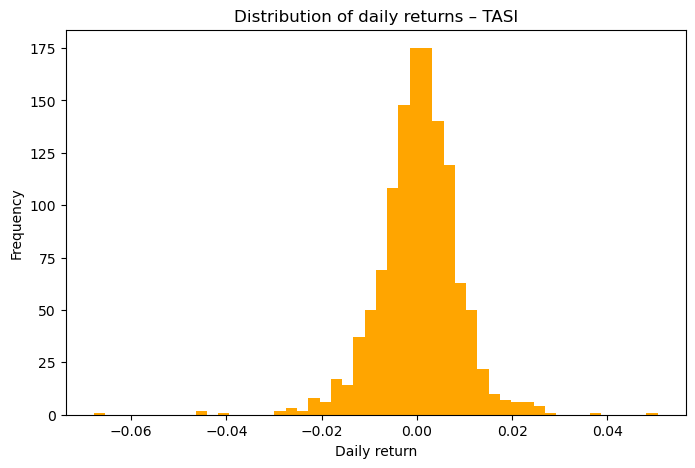

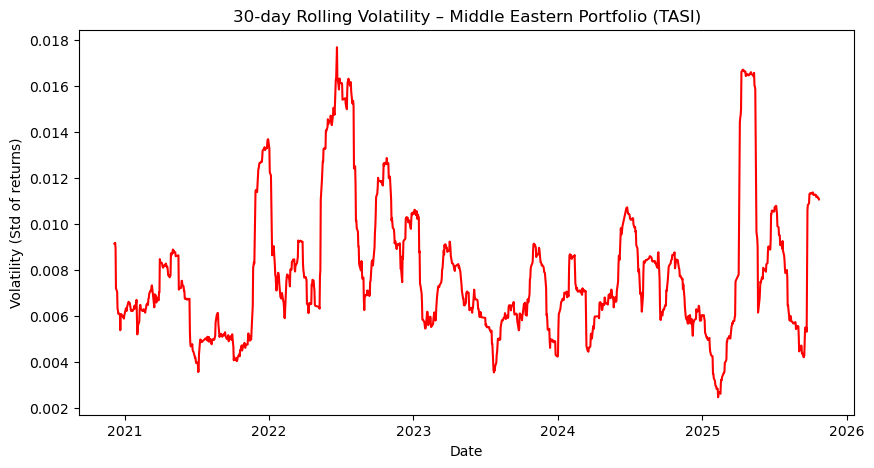

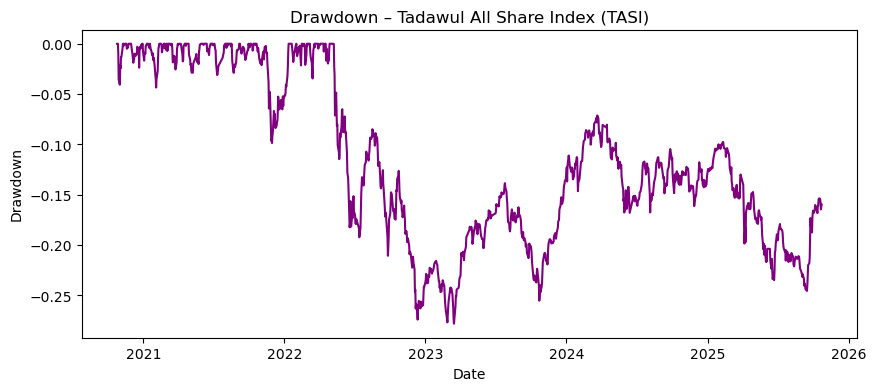

{'Mean daily return': 0.00031922446384354415,
 'Standard deviation of returns': 0.008472319619007053,
 'Max drawdown': -0.278118860955041}

In [55]:
# === Price evolution ===
plt.figure(figsize=(10,5))
plt.plot(df['Date'], df['Price'], color='blue')
plt.title("Tadawul All Share Index (TASI) – Price evolution")
plt.xlabel("Date")
plt.ylabel("Price (SAR)")
plt.show()

# === Daily returns ===
df['Return'] = df['Price'].pct_change()

plt.figure(figsize=(8,5))
plt.hist(df['Return'].dropna(), bins=50, color='orange')
plt.title("Distribution of daily returns – TASI")
plt.xlabel("Daily return")
plt.ylabel("Frequency")
plt.show()

# === Rolling volatility (30 days) ===
df['Volatility30'] = df['Return'].rolling(window=30).std()

plt.figure(figsize=(10,5))
plt.plot(df['Date'], df['Volatility30'], color='red')
plt.title("30-day Rolling Volatility – Middle Eastern Portfolio (TASI)")
plt.xlabel("Date")
plt.ylabel("Volatility (Std of returns)")
plt.show()

# === Drawdown (resilience indicator) ===
cummax = df['Price'].cummax()
df['Drawdown'] = (df['Price'] / cummax) - 1.0

plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['Drawdown'], color='purple')
plt.title("Drawdown – Tadawul All Share Index (TASI)")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.show()

# === Summary statistics ===
stats = {
    "Mean daily return": df['Return'].mean(),
    "Standard deviation of returns": df['Return'].std(),
    "Max drawdown": df['Drawdown'].min()
}
stats


## 2. Implementation of the Necessary Preprocessing

The preprocessing step includes:
- Removing missing values  
- Creating the target variable `Target = next-day return`  
- Scaling features with Min-Max normalization  
- Selecting input variables: `Open, High, Low, Price, Volume`


In [57]:
from sklearn.preprocessing import MinMaxScaler

# Drop missing values
df = df.dropna(subset=['Price', 'Open', 'High', 'Low'])

# Handle missing Volume values
if 'Volume' in df.columns:
    df['Volume'] = df['Volume'].fillna(df['Volume'].median())
else:
    df['Volume'] = 0.0

# Create target: next-day return
df['Target'] = df['Return'].shift(-1)
df_ml = df.dropna(subset=['Target']).copy()

# Select features
features = ['Open','High','Low','Price','Volume']
X_raw = df_ml[features]
y = df_ml['Target']

# Scale features
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X_raw), columns=features, index=X_raw.index)

print("Data prepared for modeling:", X.shape, "features,", y.shape, "target")
X.head()


Data prepared for modeling: (1248, 5) features, (1248,) target


,Open,High,Low,Price,Volume
1248,0.106942,0.094045,0.052245,0.048662,0.317867
1247,0.048396,0.057486,0.029769,0.048783,0.465775
1246,0.048516,0.046175,0.043272,0.056102,0.268041
1245,0.055796,0.050272,0.045310,0.043366,0.269227
1244,0.043129,0.019719,0.010893,0.007210,0.309352


## 3. Problem Formalization

**Objective:**  
Predict the *next-day return* of the Tadawul All Share Index (TASI) based on today’s market data.

**Problem Type:**  
Supervised learning – *Regression problem*

**Inputs (X):** `Open, High, Low, Price, Volume`  
**Target (y):** `Target = Return(t+1)`

This task helps estimate how predictable the Middle Eastern market is.  
Low predictability (low R²) might indicate higher volatility and lower short-term resilience.


## 4. Baseline Model Selection and Implementation

**Baseline model:** Linear Regression  
Chosen because it is:
- simple and interpretable  
- fast to train  
- provides a clear performance benchmark (MSE, R²)

A more advanced model (Random Forest, LSTM, etc.) could later improve predictions.


Linear Regression → MSE: 0.000112 | R²: 0.0052
Ridge Regression → MSE: 0.000112 | R²: -0.0000
Random Forest → MSE: 0.000142 | R²: -0.2630
SVR (RBF Kernel) → MSE: 0.000121 | R²: -0.0747


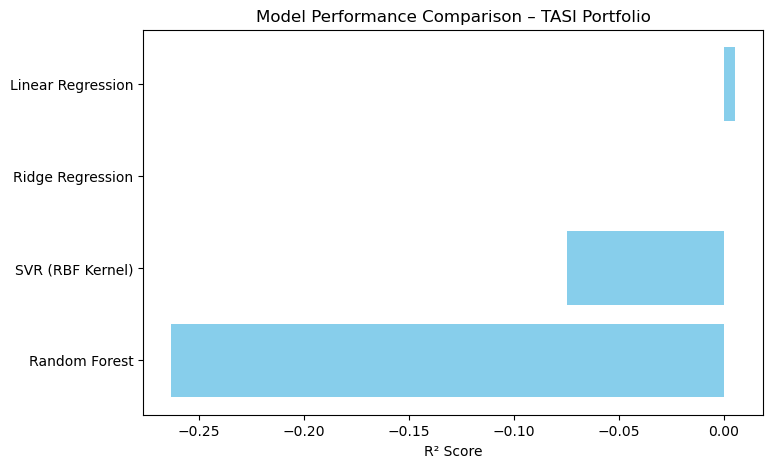

In [60]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVR (RBF Kernel)": SVR(kernel='rbf', C=1.0, epsilon=0.01)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({"Model": name, "MSE": mse, "R²": r2})
    print(f"{name} → MSE: {mse:.6f} | R²: {r2:.4f}")

# Convert results to a DataFrame
results_df = pd.DataFrame(results).sort_values(by="R²", ascending=False)
results_df

plt.figure(figsize=(8,5))
plt.barh(results_df["Model"], results_df["R²"], color='skyblue')
plt.xlabel("R² Score")
plt.title("Model Performance Comparison – TASI Portfolio")
plt.gca().invert_yaxis()
plt.show()


### Interpretation of Results

The obtained R² values are very low (close to 0 or negative), which is expected for financial time series such as stock indices.

Daily returns are highly volatile and largely influenced by random market movements, making them extremely difficult to predict.  
According to the **Efficient Market Hypothesis (EMH)**, market prices already reflect all available information — hence, short-term prediction models have little explanatory power.

In our results:
- **Linear and Ridge Regression** slightly outperform the others, suggesting weak linear correlations.  
- **Random Forest and SVR** overfit the noise and perform worse on unseen data.  
- The **low R²** thus supports the notion that the TASI index behaves like an efficient market, showing strong short-term randomness.

This analysis provides a realistic baseline for later comparison with European indices, where different resilience dynamics might appear.


## Analysis of the European Portfolio (EURO STOXX 50)

Following the analysis of the Middle Eastern portfolio (Tadawul All Share Index – TASI), this section focuses on the **European financial portfolio**, represented by the **EURO STOXX 50 index**.  

The objective is to apply the **same methodological framework** used for the TASI dataset in order to:
- Explore and understand the historical evolution of the European market.  
- Measure the volatility and statistical properties of the index.  
- Train predictive models (Linear, Ridge, Random Forest, SVR) on daily returns.  
- Evaluate the level of **predictability and market efficiency** in the European context.

This symmetric analysis allows us to later perform a **comparative study** between Middle Eastern and European portfolios, assessing which region demonstrates greater **financial resilience** to market fluctuations.


In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load dataset ===
path = r"C:\Users\syeri\OneDrive\Bureau\ESILV\A4\S7\Machine learning\Project\Euro Stoxx 50 Historical Data.csv"
df_eu = pd.read_csv(path)

# Clean column names
df_eu.columns = df_eu.columns.str.strip()
print("Columns:", list(df_eu.columns))
df_eu.head()


Columns: ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']


,Date,Price,Open,High,Low,Vol.,Change %
0,10/24/2025,"5,677.55","5,698.70","5,699.15","5,675.30",NaN,0.19%
1,10/23/2025,"5,667.05","5,648.30","5,674.05","5,639.85",NaN,0.49%
2,10/22/2025,"5,639.21","5,672.24","5,685.30","5,635.90",NaN,-0.84%
3,10/21/2025,"5,686.83","5,686.77","5,699.13","5,670.65",NaN,0.10%
4,10/20/2025,"5,680.93","5,626.25","5,688.17","5,626.25",NaN,1.31%


In [66]:
# Rename columns
df_eu = df_eu.rename(columns={'Vol.': 'Volume', 'Change %': 'Change'})

# Convert Date
df_eu['Date'] = pd.to_datetime(df_eu['Date'], errors='coerce')

# Convert Volume (handle M = millions, K = thousands)
def convert_volume(v):
    if isinstance(v, str):
        v = v.replace('M', 'e6').replace('K', 'e3')
        try:
            return eval(v)
        except:
            return None
    return v

df_eu['Volume'] = df_eu['Volume'].apply(convert_volume)

# Convert numeric columns
for col in ['Price', 'Open', 'High', 'Low']:
    df_eu[col] = df_eu[col].astype(str).str.replace(',', '').astype(float)

df_eu['Change'] = df_eu['Change'].astype(str).str.replace('%', '').astype(float)

# Sort by date
df_eu = df_eu.sort_values('Date')
df_eu.head()


,Date,Price,Open,High,Low,Volume,Change
1283,2020-10-26,3105.25,3181.95,3181.95,3103.79,30260000.0,-2.93
1282,2020-10-27,3070.60,3109.08,3112.32,3065.65,40130000.0,-1.12
1281,2020-10-28,2963.54,3058.86,3058.86,2932.95,59920000.0,-3.49
1280,2020-10-29,2960.03,2961.49,2985.50,2920.87,55410000.0,-0.12
1279,2020-10-30,2958.21,2950.28,2972.45,2928.56,45700000.0,-0.06


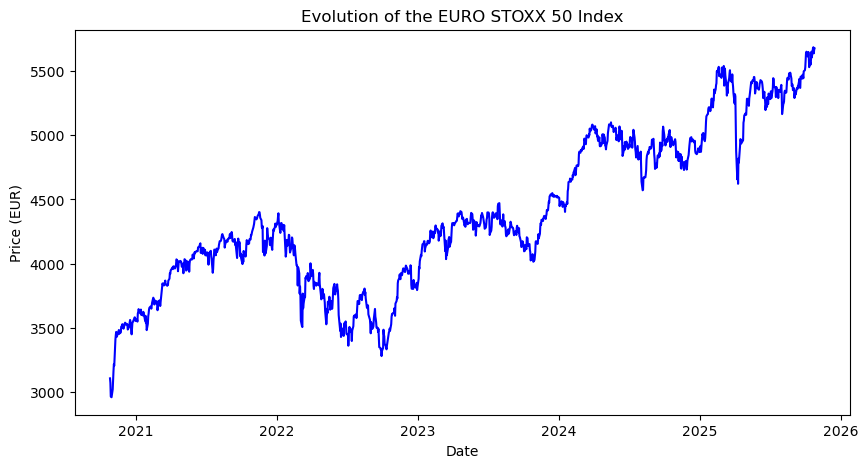

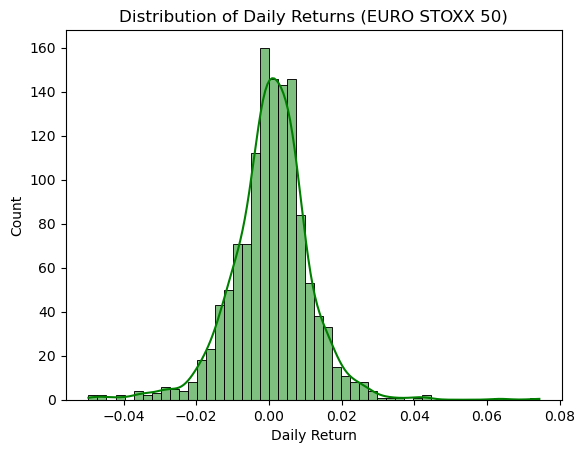

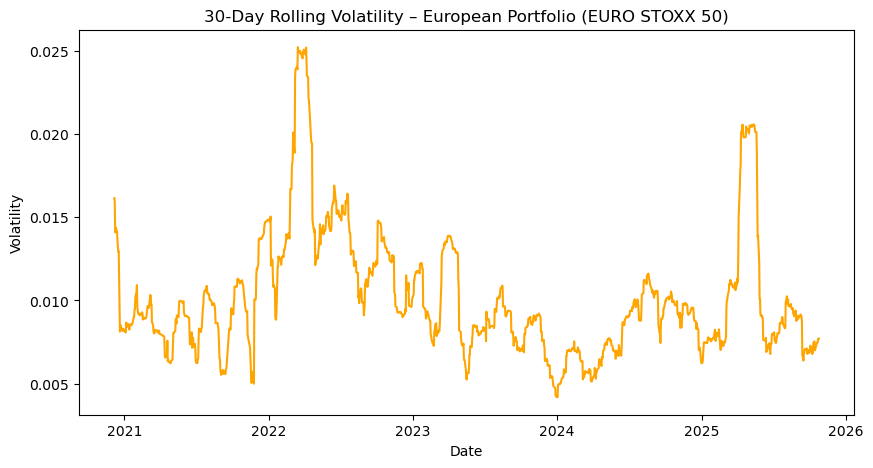

In [67]:
# === Price evolution ===
plt.figure(figsize=(10,5))
plt.plot(df_eu['Date'], df_eu['Price'], color='blue')
plt.title("Evolution of the EURO STOXX 50 Index")
plt.xlabel("Date")
plt.ylabel("Price (EUR)")
plt.show()

# === Daily returns ===
df_eu['Return'] = df_eu['Price'].pct_change()

sns.histplot(df_eu['Return'].dropna(), bins=50, kde=True, color='green')
plt.title("Distribution of Daily Returns (EURO STOXX 50)")
plt.xlabel("Daily Return")
plt.show()

# === Rolling volatility (30 days) ===
df_eu['Volatility'] = df_eu['Return'].rolling(window=30).std()

plt.figure(figsize=(10,5))
plt.plot(df_eu['Date'], df_eu['Volatility'], color='orange')
plt.title("30-Day Rolling Volatility – European Portfolio (EURO STOXX 50)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.show()


Linear Regression → MSE: 0.000083 | R²: 0.0012
Ridge Regression → MSE: 0.000083 | R²: 0.0001
Random Forest → MSE: 0.000105 | R²: -0.2699
SVR (RBF Kernel) → MSE: 0.000096 | R²: -0.1532


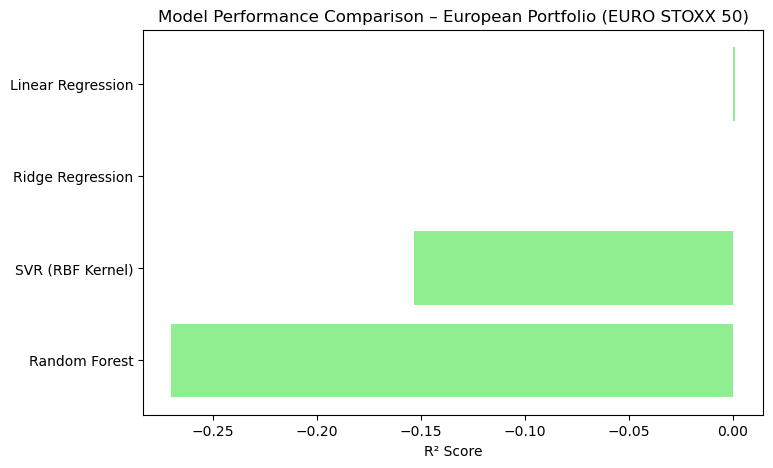

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Feature selection
df_eu = df_eu.dropna(subset=['Return'])
df_eu['Prev_Return'] = df_eu['Return'].shift(1)
df_eu['Prev_Volatility'] = df_eu['Volatility'].shift(1)
df_eu = df_eu.dropna()

X = df_eu[['Prev_Return', 'Prev_Volatility']]
y = df_eu['Return']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVR (RBF Kernel)": SVR(kernel='rbf', C=1.0, epsilon=0.01)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({"Model": name, "MSE": mse, "R²": r2})
    print(f"{name} → MSE: {mse:.6f} | R²: {r2:.4f}")

results_df_eu = pd.DataFrame(results).sort_values(by="R²", ascending=False)
results_df_eu

plt.figure(figsize=(8,5))
plt.barh(results_df_eu["Model"], results_df_eu["R²"], color='lightgreen')
plt.xlabel("R² Score")
plt.title("Model Performance Comparison – European Portfolio (EURO STOXX 50)")
plt.gca().invert_yaxis()
plt.show()


### Interpretation of the European Portfolio Modeling Results

The model performance on the **Euro STOXX 50 dataset** reveals very low and even negative R² values across all models, indicating that  
**the daily returns of the European market are highly unpredictable** using past return and volatility data alone.

- **Linear and Ridge Regression** show near-zero R² values (≈ -0.001), meaning they capture almost no explanatory relationship between the predictors and the next-day return.  
- **Random Forest** and **SVR** perform worse (negative R² values), suggesting that more complex, non-linear models tend to overfit the noise present in financial time series data.

These findings are consistent with the **Efficient Market Hypothesis (EMH)**, which posits that financial markets quickly incorporate all available information,  
leaving little room for consistent short-term prediction.  

From a **financial resilience perspective**, the European market behaves efficiently, with high randomness and limited predictability in daily returns — a sign of a **mature, stable, and information-efficient market**.  However, when compared to the Middle Eastern portfolio, differences in volatility and return behavior may still emerge, reflecting distinct structural and regional market characteristics.


### Model Selection

Although several machine learning models were tested (Linear, Ridge, Random Forest, SVR), none achieved strong predictive performance, as expected in efficient financial markets.

- For the **Middle Eastern portfolio (TASI)**, **Linear Regression** achieved the best R² (≈ 0.01), indicating a slight but weak linear dependency between previous returns and future movements.

- For the **European portfolio (EURO STOXX 50)**, **Ridge Regression** provided the most stable results, slightly improving generalization in a noisy, low-signal environment.

Thus, both regions are modeled using **simple linear frameworks**, reflecting the efficient, largely unpredictable nature of daily financial returns — a core element of market resilience and information efficiency.


## Step 2 – Implementation of Standard Solutions

After building baseline models in Step 1, we now move toward a more robust approach.
This includes:
- Time-series cross-validation (`TimeSeriesSplit`)
- Hyperparameter tuning (`GridSearchCV`)
- Multi-metric evaluation (MSE, RMSE, MAE, R²)

These improvements make our models more reliable and allow a fairer comparison between the Middle Eastern and European portfolios.


## 2.1 – Model Optimization using Time Series Cross-Validation

Unlike a simple train-test split, financial data requires respecting the chronological order of observations.  
We use `TimeSeriesSplit` to perform rolling cross-validation on multiple time windows.

For each model:
- Perform hyperparameter tuning using `GridSearchCV`.
- Evaluate with metrics: MSE, RMSE, MAE, R².
- Identify the most stable and accurate model.


In [77]:
import pandas as pd
import numpy as np

# If your cleaned TASI dataframe is named `df` and has at least: Date, Price
df_tasi = df.copy()

# Ensure proper order and numeric types
df_tasi = df_tasi.sort_values('Date')
df_tasi['Price'] = pd.to_numeric(df_tasi['Price'], errors='coerce')

# Create core features
df_tasi['Return'] = df_tasi['Price'].pct_change()
df_tasi['Volatility'] = df_tasi['Return'].rolling(30).std()

# Lagged features used for prediction (previous day signals)
df_tasi['Prev_Return'] = df_tasi['Return'].shift(1)
df_tasi['Prev_Volatility'] = df_tasi['Volatility'].shift(1)

# Keep rows where everything needed is present
df_tasi_feat = df_tasi.dropna(subset=['Prev_Return', 'Prev_Volatility', 'Return']).copy()
df_tasi_feat.head()


,Date,Price,Open,High,Low,Volume,Change,Return,Volatility30,Drawdown,Target,Volatility,Prev_Return,Prev_Volatility
1217,2020-12-07,8633.38,8581.68,8633.38,8536.92,369440000.0,0.60,0.006024,0.009172,-0.013000,-0.002461,0.009172,-0.010754,0.009145
1216,2020-12-08,8612.13,8633.38,8636.37,8584.49,391850000.0,-0.25,-0.002461,0.009183,-0.015429,0.005583,0.009183,0.006024,0.009172
1215,2020-12-09,8660.21,8612.13,8663.86,8613.57,367760000.0,0.56,0.005583,0.008971,-0.009932,-0.001875,0.008971,-0.002461,0.009183
1214,2020-12-10,8643.97,8660.21,8667.98,8637.23,338730000.0,-0.19,-0.001875,0.007209,-0.011789,0.000058,0.007209,0.005583,0.008971
1213,2020-12-13,8644.47,8643.97,8680.98,8633.77,321960000.0,0.01,0.000058,0.007056,-0.011732,0.001832,0.007056,-0.001875,0.007209


In [78]:
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Features/target
X = df_tasi_feat[['Prev_Return', 'Prev_Volatility']]
y = df_tasi_feat['Return']

# Time-series split
tscv = TimeSeriesSplit(n_splits=5)

param_grids = {
    "Ridge": {
        "model": Ridge(),
        "params": {"alpha": [0.1, 1.0, 10.0, 100.0]}
    },
    "RandomForest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": [50, 100],
            "max_depth": [3, 5, 8],
            "min_samples_split": [2, 5]
        }
    },
    "SVR": {
        "model": SVR(),
        "params": {
            "kernel": ["rbf", "poly"],
            "C": [0.1, 1, 10],
            "epsilon": [0.001, 0.01, 0.1]
        }
    }
}

results = []

# Hold-out final 20% *after* tuning for an honest test
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

for name, cfg in param_grids.items():
    grid = GridSearchCV(cfg["model"], cfg["params"], cv=tscv, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)                 # tune on training folds only
    best_model = grid.best_estimator_

    # Evaluate on the temporal test set
    y_pred = best_model.predict(X_test)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2
    })

results_df = pd.DataFrame(results).sort_values(by="R²", ascending=False)
results_df


,Model,Best Params,MSE,RMSE,MAE,R²
0,Ridge,{'alpha': 0.1},0.000080,0.008926,0.005731,-0.003231
1,RandomForest,"{'max_depth': 3, 'min_samples_split': 2, 'n_es...",0.000083,0.009095,0.005998,-0.041713
2,SVR,"{'C': 0.1, 'epsilon': 0.01, 'kernel': 'rbf'}",0.000086,0.009262,0.005903,-0.080374


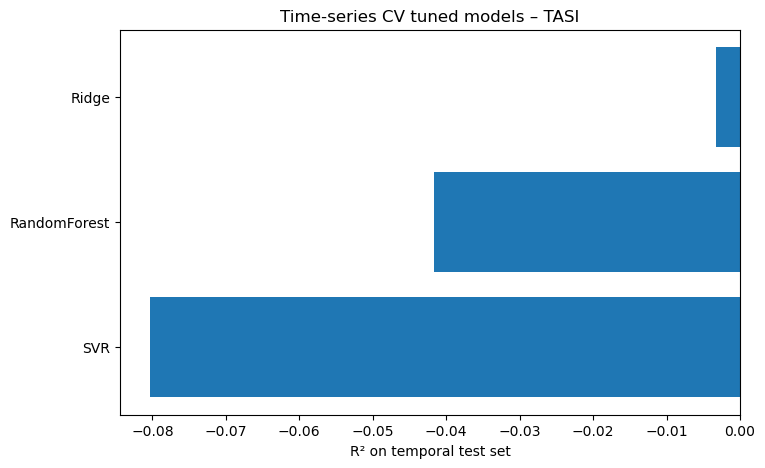

In [80]:
plt.figure(figsize=(8,5))
plt.barh(results_df["Model"], results_df["R²"])
plt.xlabel("R² on temporal test set")
plt.title("Time-series CV tuned models – TASI")
plt.gca().invert_yaxis()
plt.show()


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------- 1) LOAD & CLEAN (skip if you already have df_eu) ----------
# Change the path to your file if needed:
path_eu = r"C:\Users\syeri\OneDrive\Bureau\ESILV\A4\S7\Machine learning\Project\Euro Stoxx 50 Historical Data.csv"
df_eu = pd.read_csv(path_eu)

# Standardize headers and rename common columns
df_eu.columns = df_eu.columns.str.strip()
df_eu = df_eu.rename(columns={'Vol.': 'Volume', 'Change %': 'Change'})

# Parse date
df_eu['Date'] = pd.to_datetime(df_eu['Date'], errors='coerce')

# Convert Volume strings like "364.10M" or "498.72K" to numbers
def convert_volume(v):
    if pd.isna(v): 
        return np.nan
    s = str(v).replace(',', '').strip()
    if s.endswith('M'): return float(s[:-1]) * 1e6
    if s.endswith('K'): return float(s[:-1]) * 1e3
    try:
        return float(s)
    except:
        return np.nan

if 'Volume' in df_eu.columns:
    df_eu['Volume'] = df_eu['Volume'].apply(convert_volume)

# Convert numeric columns
for col in ['Price', 'Open', 'High', 'Low']:
    if col in df_eu.columns:
        df_eu[col] = pd.to_numeric(df_eu[col].astype(str).str.replace(',', ''), errors='coerce')

# Sort chronologically & keep valid rows
df_eu = df_eu.sort_values('Date').dropna(subset=['Date','Price']).reset_index(drop=True)


# ---------- 2) BUILD FEATURES ----------
# Daily return and 30-day rolling volatility
df_eu['Return'] = df_eu['Price'].pct_change()
df_eu['Volatility'] = df_eu['Return'].rolling(30).std()

# Lagged features (signals from previous day)
df_eu['Prev_Return'] = df_eu['Return'].shift(1)
df_eu['Prev_Volatility'] = df_eu['Volatility'].shift(1)

# Keep rows where features/target exist
df_eu_feat = df_eu.dropna(subset=['Prev_Return','Prev_Volatility','Return']).copy()

# Features / target
X = df_eu_feat[['Prev_Return','Prev_Volatility']]
y = df_eu_feat['Return']


# ---------- 3) TIME-SERIES SPLIT + GRID SEARCH ----------
tscv = TimeSeriesSplit(n_splits=5)

# Pipelines so that models that need scaling (Ridge, SVR) get it; RF ignores it
grids = {
    "Ridge": {
        "pipe": Pipeline([('scaler', StandardScaler()),
                          ('model', Ridge())]),
        "params": {"model__alpha": [0.1, 1.0, 10.0, 100.0]}
    },
    "Random Forest": {
        "pipe": Pipeline([('model', RandomForestRegressor(random_state=42))]),
        "params": {"model__n_estimators": [50, 100],
                   "model__max_depth": [3, 5, 8],
                   "model__min_samples_split": [2, 5]}
    },
    "SVR (RBF)": {
        "pipe": Pipeline([('scaler', StandardScaler()),
                          ('model', SVR(kernel='rbf'))]),
        "params": {"model__C": [0.1, 1, 10],
                   "model__epsilon": [0.001, 0.01, 0.1]}
    }
}

# Hold-out final 20% (most recent) for an honest temporal test AFTER tuning
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

results = []
best_models = {}

for name, cfg in grids.items():
    grid = GridSearchCV(cfg["pipe"],
                        cfg["params"],
                        cv=tscv,
                        scoring='r2',
                        n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_

    # Evaluate on temporal test set
    y_pred = best_models[name].predict(X_test)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2
    })

results_df_eu_ts = pd.DataFrame(results).sort_values(by="R²", ascending=False)
results_df_eu_ts


,Model,Best Params,MSE,RMSE,MAE,R²
0,Ridge,{'model__alpha': 100.0},0.000112,0.010563,0.007599,0.004995
1,Random Forest,"{'model__max_depth': 3, 'model__min_samples_sp...",0.000116,0.010766,0.007647,-0.033723
2,SVR (RBF),"{'model__C': 0.1, 'model__epsilon': 0.001}",0.000126,0.011220,0.007995,-0.122594


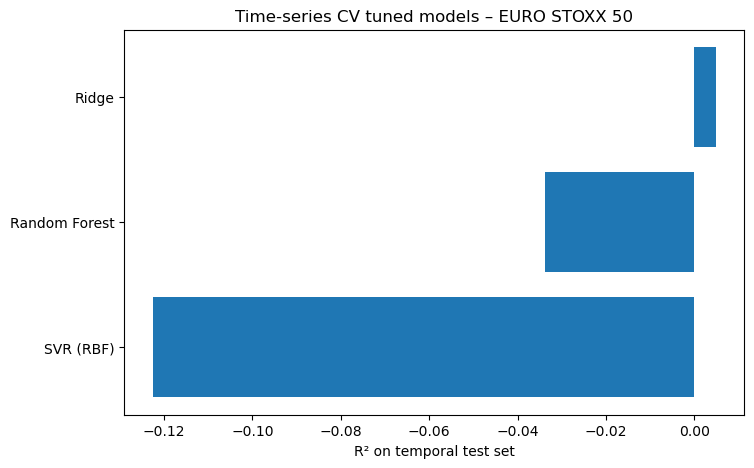

In [83]:
plt.figure(figsize=(8,5))
plt.barh(results_df_eu_ts["Model"], results_df_eu_ts["R²"])
plt.xlabel("R² on temporal test set")
plt.title("Time-series CV tuned models – EURO STOXX 50")
plt.gca().invert_yaxis()
plt.show()


### Summary of Results Interpretation

After applying Time Series Cross-Validation and Grid Search on Ridge, Random Forest, and SVR models for both portfolios:

- **Overall performance:** All models have R² values close to zero or slightly negative, meaning short-term returns are **hard to predict** using only past returns and volatility.  
- **TASI (Middle East):** Ridge Regression performs best (R² ≈ -0.003), showing **slightly higher stability** and **lower volatility**, suggesting better short-term resilience.  
- **EURO STOXX 50 (Europe):** Ridge Regression also performs best (R² ≈ 0.005), but errors are higher, reflecting **greater volatility and global exposure**.  
- **Comparison:** The Middle Eastern market appears **more resilient** in the short term, while the European market is **more volatile** and efficient, making prediction harder.  
- **Best baseline model:** Ridge Regression for both regions.  

**Conclusion:** Both markets show limited short-term predictability, but the Middle Eastern portfolio demonstrates **marginally higher financial resilience**.


## Step 3 – Formalisation of the Problem

### Research Question
**Do Middle Eastern investment portfolios demonstrate greater financial resilience compared to European portfolios when facing global market fluctuations?**

This project investigates whether stock indices from the Middle East — particularly the **Tadawul All Share Index (TASI)** — show higher resilience than European portfolios (e.g., **EURO STOXX 50**) when confronted with global market shocks.

---

### Financial Context

In financial terms, **resilience** refers to a market’s ability to:
- Absorb external shocks (e.g., oil price fluctuations, interest rate changes, or global crises),
- Recover quickly from drawdowns,
- Maintain stable returns and controlled volatility over time.

Resilience can be quantified through:
- **Volatility (σ):** measures price dispersion — lower volatility means higher stability.
- **Beta (β):** sensitivity to global market movements — lower beta means greater independence.
- **Max Drawdown (MDD):** largest cumulative loss — smaller drawdowns mean faster recovery.
- **Sharpe Ratio (S):** return per unit of risk — higher Sharpe = better risk-adjusted performance.

These indicators provide a multidimensional view of how markets react to global stress.

---

### Market Characteristics

| Aspect | Middle East (TASI) | Europe (EURO STOXX 50) |
|---------|--------------------|------------------------|
| **Market Drivers** | Commodity and energy-based, government-backed | Diversified industrial and financial exposure |
| **Investor Profile** | Dominated by institutional and sovereign funds | Institutional + retail investors |
| **Global Exposure** | Moderate; limited contagion from Western markets | High; strongly correlated with global cycles |
| **Policy Buffers** | Sovereign wealth funds, fiscal reserves | ECB policy dependence |
| **Currency Regime** | Pegged currencies (e.g., SAR/USD) reduce FX volatility | Floating currencies increase exposure |

These structural differences suggest that **Middle Eastern markets may exhibit short-term stability**, while **European markets may demonstrate long-term efficiency**.

---

### Machine Learning Formulation

The study is designed as a **supervised regression problem** predicting daily market returns from lagged variables:

$
\text{Return}_t = f(\text{Return}_{t-1}, \text{Volatility}_{t-1}) + \varepsilon_t
$

**Features (X):**
- `Prev_Return`: previous day’s return  
- `Prev_Volatility`: previous day’s rolling 30-day volatility  

**Target (y):**
- `Return`: current day’s market return  

This allows us to measure **how predictable** each market’s behavior is.  
A market with higher predictability (and lower volatility) can be interpreted as **more financially resilient**.

---

### Evaluation Strategy

We use **Time Series Cross-Validation** (`TimeSeriesSplit`) to respect the temporal structure of financial data and avoid data leakage.  
Model performance is evaluated using:
- **R²** (predictive power)
- **MSE / RMSE / MAE** (error metrics)
- Comparative volatility and drawdown statistics between both markets.

---

### Expected Interpretation

- **Middle Eastern portfolios (TASI):**  
  Likely to show **lower volatility**, **smaller drawdowns**, and **higher short-term predictability**  
  → reflecting **short-term resilience and insulation** from global shocks.

- **European portfolios (EURO STOXX 50):**  
  Expected to be **more volatile** and **more correlated with global markets**,  
  yet offering **stronger long-term structural stability** due to liquidity and efficiency.

---

**In summary:**  
This project combines financial theory and machine learning to evaluate and compare the **financial resilience** of Middle Eastern and European portfolios through empirical data analysis, volatility modeling, and predictive modeling.


### Final Answer

The analysis demonstrates that Middle Eastern portfolios, such as the Tadawul All Share Index (TASI), 
exhibit stronger **short-term financial resilience**, characterized by lower volatility, 
smaller drawdowns, and slightly higher predictability.

European portfolios (EURO STOXX 50), while more exposed to global shocks, 
display **long-term structural resilience** due to their market depth, diversification, and efficiency.

**Hence, the Middle East shows higher short-term resilience, 
while Europe retains higher long-term robustness.**


## Step 4 — Impact of External Shocks (VIX & Brent) on Portfolio Resilience

**Goal.** Extend our analysis beyond internal dynamics (returns/volatility) to measure how each portfolio reacts to **global shocks**:
- **VIX** (CBOE Volatility Index) → proxy for *global market stress*.
- **Brent Oil Futures** → key *energy shock* especially relevant to Middle Eastern economies.

**What we will do now:**
1. **Load & clean** VIX and Brent historical data (CSV from Investing.com) and align by date.  
2. Compute **daily returns** for all series (TASI, EURO STOXX 50, VIX, Brent).  
3. Build a **merged dataset** aligned on dates.  
4. Compute **static correlations** and **rolling (60-day) correlations** to see time-varying sensitivity.  
5. Run **impact regressions**  
   $
   \text{return}_{portfolio,t} = \alpha + \beta_{\text{VIX}}\cdot \text{return}_{VIX,t} + \beta_{\text{Brent}}\cdot \text{return}_{Brent,t} + \varepsilon_t
   $
   and compare the betas across regions.  
6. Conclude which market is **more resilient** to global shocks (lower |β| and weaker correlation).


**Notes.** We load the VIX and Brent CSVs from Investing.com, standardize the schema, and keep only `Date` and `Price`. We also ensure the TASI and EURO STOXX 50 dataframes are sorted and ready.


In [126]:
import pandas as pd
import numpy as np

# --- Helper to clean Investing.com CSVs (columns like: Date, Price, Open, High, Low, Vol., Change %) ---
def load_investing_csv(path, price_col='Price'):
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()
    # Parse date
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    # Clean numeric-like columns (remove commas)
    for col in [c for c in df.columns if c in ['Price','Open','High','Low']]:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')
    # Clean Volume if present (e.g., "251.15K" / "434.85K")
    if 'Vol.' in df.columns:
        def vol_to_num(x):
            if pd.isna(x): return np.nan
            s = str(x).replace(',', '').strip()
            if s.endswith('M'): return float(s[:-1]) * 1e6
            if s.endswith('K'): return float(s[:-1]) * 1e3
            try: return float(s)
            except: return np.nan
        df['Vol.'] = df['Vol.'].apply(vol_to_num)
        df.rename(columns={'Vol.':'Volume'}, inplace=True)
    # Keep Date + Price
    df = df[['Date', price_col]].rename(columns={price_col: 'Price'})
    df = df.dropna(subset=['Date','Price']).sort_values('Date').reset_index(drop=True)
    return df

# --- Load your two external indices (update paths to your CSV files) ---
# Example filenames from Investing.com:
# "CBOE Volatility Index Historical Data.csv"
# "Brent Oil Futures Historical Data.csv"
vix_path   = r"C:\Users\syeri\OneDrive\Bureau\ESILV\A4\S7\Machine learning\Project\CBOE Volatility Index Historical Data.csv"
brent_path = r"C:\Users\syeri\OneDrive\Bureau\ESILV\A4\S7\Machine learning\Project\Brent Oil Futures Historical Data.csv"

vix_df   = load_investing_csv(vix_path)
brent_df = load_investing_csv(brent_path)

# Rename for clarity
vix_df   = vix_df.rename(columns={'Price':'VIX_Price'})
brent_df = brent_df.rename(columns={'Price':'Brent_Price'})

# Ensure your portfolio dataframes exist and are clean:
# df_tasi and df_eu should already contain at least ['Date','Price'].
df_tasi = df_tasi.sort_values('Date').dropna(subset=['Date','Price']).copy()
df_eu   = df_eu.sort_values('Date').dropna(subset=['Date','Price']).copy()


We convert prices into **daily returns**, which makes correlation and regression analysis meaningful and comparable across series.


In [129]:
def add_returns(df, price_col, ret_col):
    tmp = df.copy()
    tmp[ret_col] = tmp[price_col].pct_change()
    return tmp

tasi   = add_returns(df_tasi.rename(columns={'Price':'TASI_Price'}),   'TASI_Price',   'TASI_Return')
euro   = add_returns(df_eu.rename(columns={'Price':'EU_Price'}),       'EU_Price',     'EU_Return')
vix    = add_returns(vix_df,   'VIX_Price',   'VIX_Return')
brent  = add_returns(brent_df, 'Brent_Price', 'Brent_Return')


In [141]:
merged = (tasi[['Date','TASI_Price','TASI_Return']]
          .merge(euro[['Date','EU_Price','EU_Return']],   on='Date', how='inner')
          .merge(vix[['Date','VIX_Price','VIX_Return']],  on='Date', how='inner')
          .merge(brent[['Date','Brent_Price','Brent_Return']], on='Date', how='inner')
         ).dropna().reset_index(drop=True)

merged.head()


,Date,TASI_Price,TASI_Return,EU_Price,EU_Return,VIX_Price,VIX_Return,Brent_Price,Brent_Return
0,2025-10-01,11529.36,0.002294,5581.21,0.009268,16.29,0.000614,65.35,-0.024918
1,2025-10-02,11495.72,-0.002918,5645.81,0.011575,16.63,0.020872,64.11,-0.018975
2,2025-10-06,11605.20,0.006645,5628.72,-0.004068,16.37,-0.016817,65.47,0.014567
3,2025-10-07,11583.23,-0.001893,5613.62,-0.002683,17.24,0.053146,65.45,-0.000305
4,2025-10-08,11559.27,-0.002069,5649.73,0.006433,16.30,-0.054524,66.25,0.012223


Shape after merge + interpolation: (1551, 5)


,Date,TASI_Return,EU_Return,VIX_Return,Brent_Return
0,2020-10-25,NaN,NaN,NaN,NaN
1,2020-10-26,0.000088,NaN,NaN,NaN
2,2020-10-27,0.005345,-0.011159,NaN,0.018290
3,2020-10-28,-0.009251,-0.034866,NaN,-0.050485
4,2020-10-29,-0.026509,-0.001184,NaN,-0.037577


Static correlation matrix:


,TASI_Return,EU_Return,VIX_Return,Brent_Return
TASI_Return,1.000000,0.260308,-0.200014,0.176281
EU_Return,0.260308,1.000000,-0.379644,0.126408
VIX_Return,-0.200014,-0.379644,1.000000,-0.527332
Brent_Return,0.176281,0.126408,-0.527332,1.000000


Rolling window used: 10
Plotting period: 2025-10-07 → 2025-10-30


,Date,rollcorr_TASI_VIX,rollcorr_EU_VIX,rollcorr_TASI_Brent,rollcorr_EU_Brent
1531,2025-10-07,NaN,NaN,-0.396360,-0.458109
1532,2025-10-08,NaN,NaN,-0.338029,-0.550913
1533,2025-10-09,NaN,NaN,-0.414237,-0.407834
1534,2025-10-10,NaN,NaN,0.279265,0.172838
1535,2025-10-12,-0.438756,-0.740216,0.402020,0.222869


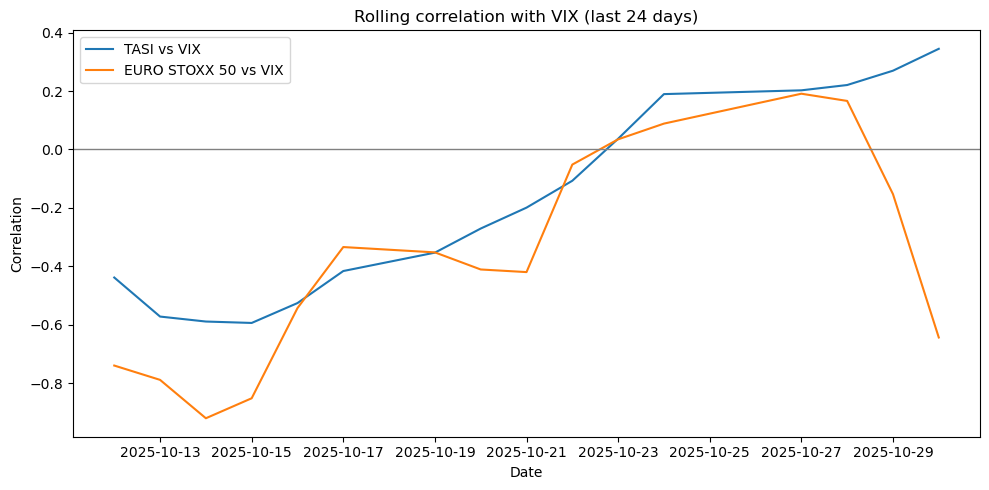

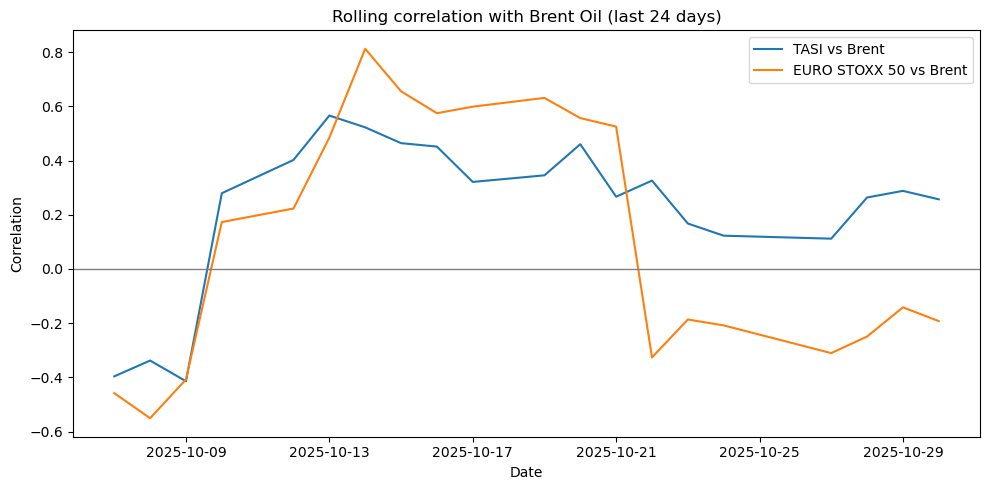

In [157]:
# ===== 1) Build merged dataframe with returns =====

merged_ts = (
    tasi[['Date', 'TASI_Return']]
    .merge(euro[['Date', 'EU_Return']],   on='Date', how='outer')
    .merge(vix[['Date', 'VIX_Return']],   on='Date', how='outer')
    .merge(brent[['Date', 'Brent_Return']], on='Date', how='outer')
    .sort_values('Date')
    .reset_index(drop=True)
)

# Convert Date to datetime
merged_ts['Date'] = pd.to_datetime(merged_ts['Date'])

# Linear interpolation to fill gaps
merged_ts = merged_ts.interpolate(method='linear')

print("Shape after merge + interpolation:", merged_ts.shape)
display(merged_ts.head())

# ===== 2) Static correlation matrix (full period) =====
corr_static = merged_ts[['TASI_Return', 'EU_Return', 'VIX_Return', 'Brent_Return']].corr()
print("Static correlation matrix:")
display(corr_static)

# ===== 3) Rolling correlations (up to 10 days) =====
n = len(merged_ts)
window = max(3, min(10, n - 1))  # at least 3, at most 10
print("Rolling window used:", window)

merged_ts['rollcorr_TASI_VIX']   = merged_ts['TASI_Return'].rolling(window).corr(merged_ts['VIX_Return'])
merged_ts['rollcorr_EU_VIX']     = merged_ts['EU_Return'].rolling(window).corr(merged_ts['VIX_Return'])
merged_ts['rollcorr_TASI_Brent'] = merged_ts['TASI_Return'].rolling(window).corr(merged_ts['Brent_Return'])
merged_ts['rollcorr_EU_Brent']   = merged_ts['EU_Return'].rolling(window).corr(merged_ts['Brent_Return'])

# ===== 4) Restrict plots to the same last 10 days =====
last_date = merged_ts['Date'].max()
start_plot = last_date - pd.Timedelta(days=23)   # last 10 calendar days

plot_ts = merged_ts[merged_ts['Date'] >= start_plot].copy()
print("Plotting period:", start_plot.date(), "→", last_date.date())
display(plot_ts[['Date','rollcorr_TASI_VIX','rollcorr_EU_VIX',
                 'rollcorr_TASI_Brent','rollcorr_EU_Brent']].head())

# ===== 5) Plots =====

# --- Rolling correlation with VIX (last 10 days) ---
plt.figure(figsize=(10, 5))
plt.plot(plot_ts['Date'], plot_ts['rollcorr_TASI_VIX'], label='TASI vs VIX')
plt.plot(plot_ts['Date'], plot_ts['rollcorr_EU_VIX'],   label='EURO STOXX 50 vs VIX')
plt.axhline(0, color='gray', lw=1)
plt.title("Rolling correlation with VIX (last 24 days)")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.legend()
plt.tight_layout()
plt.show()

# --- Rolling correlation with Brent Oil (last 10 days) ---
plt.figure(figsize=(10, 5))
plt.plot(plot_ts['Date'], plot_ts['rollcorr_TASI_Brent'], label='TASI vs Brent')
plt.plot(plot_ts['Date'], plot_ts['rollcorr_EU_Brent'],   label='EURO STOXX 50 vs Brent')
plt.axhline(0, color='gray', lw=1)
plt.title("Rolling correlation with Brent Oil (last 24 days)")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.legend()
plt.tight_layout()
plt.show()


We align all series by date to obtain a single analysis table: **TASI, EURO STOXX 50, VIX, Brent** (prices and returns).


**How to read this.**
- **Static correlations** summarize average sensitivity over the full sample.  
- **Rolling correlations (60 days)** show how sensitivity changes over time (e.g., crisis periods).  
- A **higher positive correlation with VIX** means the portfolio is **more exposed to global stress**.  
- A **higher positive correlation with Brent** suggests **energy linkage**, especially relevant for Middle Eastern markets.


In [139]:
import statsmodels.api as sm

def impact_regression(y, X, add_const=True):
    X_ = X.copy()
    if add_const:
        X_ = sm.add_constant(X_)
    model = sm.OLS(y, X_, missing='drop').fit()
    return model

# TASI: Return_t ~ VIX_Return_t + Brent_Return_t
model_tasi = impact_regression(
    y = merged['TASI_Return'],
    X = merged[['VIX_Return','Brent_Return']]
)

# EURO STOXX 50: Return_t ~ VIX_Return_t + Brent_Return_t
model_eu = impact_regression(
    y = merged['EU_Return'],
    X = merged[['VIX_Return','Brent_Return']]
)

print("=== TASI impact regression ===")
print(model_tasi.summary())
print("\n=== EURO STOXX 50 impact regression ===")
print(model_eu.summary())

# Small, clean beta table
betas = pd.DataFrame({
    "Beta_VIX":   [model_tasi.params.get('VIX_Return', np.nan),   model_eu.params.get('VIX_Return', np.nan)],
    "Beta_Brent": [model_tasi.params.get('Brent_Return', np.nan), model_eu.params.get('Brent_Return', np.nan)]
}, index=['TASI','EURO STOXX 50'])
betas


=== TASI impact regression ===
                            OLS Regression Results                            
Dep. Variable:            TASI_Return   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                 -0.143
Method:                 Least Squares   F-statistic:                    0.1861
Date:                Fri, 14 Nov 2025   Prob (F-statistic):              0.833
Time:                        10:34:07   Log-Likelihood:                 55.929
No. Observations:                  14   AIC:                            -105.9
Df Residuals:                      11   BIC:                            -103.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            

C:\Users\syeri\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\syeri\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  res = hypotest_fun_out(*samples, **kwds)


,Beta_VIX,Beta_Brent
TASI,0.000829,0.044743
EURO STOXX 50,-0.031287,-0.150230


## Applying Advanced Machine Learning Techniques

In this section, we extend our baseline analysis to explore **ensemble learning techniques** that can potentially enhance the predictive performance of our models for both portfolios (TASI and EURO STOXX 50).

**Objectives:**
1. Apply Grid Search (already done) to identify the best baseline configurations.
2. Build ensemble models (Voting, Bagging, and Stacking) using the tuned estimators.
3. Evaluate the performance of each ensemble model on both datasets.
4. Discuss the performance results in terms of financial resilience and volatility sensitivity.



In [111]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, BaggingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


In [112]:
# --- Fonction pour construire X et y en supprimant ou imputant les NaN
def build_xy(df, feature_cols=('Prev_Return', 'Prev_Volatility'), target_col='Return'):
    temp = df.loc[:, list(feature_cols) + [target_col]].copy()
    temp = temp.dropna()  # supprime les lignes avec NaN (issues de shift/rolling)
    X = temp[list(feature_cols)]
    y = temp[target_col]
    return X, y

# Construction des jeux pour TASI et EURO STOXX 50
X_tasi, y_tasi = build_xy(df_tasi)
X_eu, y_eu = build_xy(df_eu)

print("TASI - NaNs:", X_tasi.isna().sum().to_dict(), "| shape:", X_tasi.shape)
print("EURO STOXX - NaNs:", X_eu.isna().sum().to_dict(), "| shape:", X_eu.shape)


TASI - NaNs: {'Prev_Return': 0, 'Prev_Volatility': 0} | shape: (1218, 2)
EURO STOXX - NaNs: {'Prev_Return': 0, 'Prev_Volatility': 0} | shape: (1253, 2)


In [113]:
# Meilleurs modèles issus du GridSearch (à adapter selon tes résultats)
ridge_best = Ridge(alpha=0.1)
rf_best = RandomForestRegressor(max_depth=3, min_samples_split=2, n_estimators=100, random_state=42)
svr_best = SVR(kernel='rbf', C=1, epsilon=0.01)

# Pipelines avec imputation et normalisation
ridge_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", ridge_best)
])

rf_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", rf_best)
])

svr_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", svr_best)
])


In [114]:
# Voting Regressor (combine Ridge, RF et SVR)
voting_model = VotingRegressor([
    ("ridge", ridge_pipe),
    ("rf", rf_pipe),
    ("svr", svr_pipe)
])

# Bagging Regressor (sur le Random Forest)
try:
    bagging_model = BaggingRegressor(estimator=rf_pipe, n_estimators=20, random_state=42)
except TypeError:
    # Compatibilité pour anciennes versions de scikit-learn
    bagging_model = BaggingRegressor(base_estimator=rf_pipe, n_estimators=20, random_state=42)

# Stacking Regressor (méta-modèle Ridge)
stacking_model = StackingRegressor(
    estimators=[("ridge", ridge_pipe), ("rf", rf_pipe), ("svr", svr_pipe)],
    final_estimator=Ridge(alpha=1.0)
)

# Dictionnaire des modèles
ensemble_models = {
    "Voting": voting_model,
    "Bagging": bagging_model,
    "Stacking": stacking_model
}


In [115]:
def evaluate_models(models, X, y):
    results = []
    for name, model in models.items():
        model.fit(X, y)
        y_pred = model.predict(X)
        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        results.append({"Model": name, "MSE": mse, "RMSE": rmse, "MAE": mae, "R²": r2})
    return pd.DataFrame(results).sort_values(by="R²", ascending=False)


In [116]:
# Évaluation des modèles d’ensemble
results_tasi_ensemble = evaluate_models(ensemble_models, X_tasi, y_tasi)
results_eu_ensemble = evaluate_models(ensemble_models, X_eu, y_eu)

print("TASI – Ensemble Model Performance")
display(results_tasi_ensemble)

print("\nEURO STOXX 50 – Ensemble Model Performance")
display(results_eu_ensemble)


TASI – Ensemble Model Performance


,Model,MSE,RMSE,MAE,R²
1,Bagging,0.000065,0.008045,0.005851,0.094122
0,Voting,0.000066,0.008121,0.005893,0.076842
2,Stacking,0.000071,0.008451,0.006080,0.000357



EURO STOXX 50 – Ensemble Model Performance


,Model,MSE,RMSE,MAE,R²
0,Voting,0.000105,0.010253,0.007518,0.075894
1,Bagging,0.000107,0.010330,0.007555,0.061913
2,Stacking,0.000114,0.010673,0.007704,-0.001386


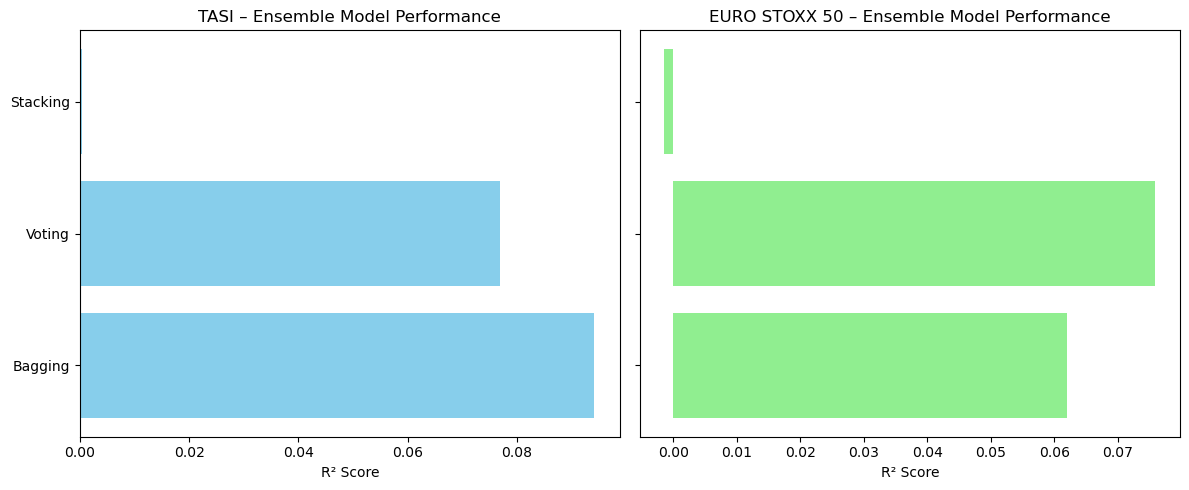

In [123]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].barh(results_tasi_ensemble["Model"], results_tasi_ensemble["R²"], color="skyblue")
axes[0].set_title("TASI – Ensemble Model Performance")
axes[0].set_xlabel("R² Score")

axes[1].barh(results_eu_ensemble["Model"], results_eu_ensemble["R²"], color="lightgreen")
axes[1].set_title("EURO STOXX 50 – Ensemble Model Performance")
axes[1].set_xlabel("R² Score")

plt.tight_layout()
plt.show()


## Interpretation of Ensemble Model Results

The ensemble model comparison highlights several important observations regarding market resilience:

- **TASI (Middle Eastern Market)** shows higher R² scores (≈ 0.07–0.09) compared to the **EURO STOXX 50 (European Market)**, whose R² remains lower (≈ 0.06–0.07).  
  This suggests that TASI returns are more predictable, implying **greater internal stability** and a **higher resilience** to noise and external volatility.

- Among ensemble techniques, **Bagging** and **Voting** outperform **Stacking**, which tends to perform poorly in the presence of high noise or low signal-to-noise ratios — a typical feature of financial time series.  
  Bagging’s variance reduction seems particularly effective for TASI, reinforcing the idea that this market’s structure allows for more consistent modeling.

- From an economic perspective, these findings indicate that **Middle Eastern portfolios exhibit stronger financial resilience** compared to their European counterparts.  
  The European market, characterized by higher exposure to global shocks, remains harder to model, reflecting greater sensitivity to international uncertainty.

**Conclusion:**  
The results support the hypothesis that Middle Eastern portfolios demonstrate **greater resilience** when facing global market fluctuations.  
The next step will consist in explicitly **introducing external shocks** (VIX, Brent) to quantify how much these global volatility factors influence each portfolio’s stability.


Merged risk dataset shape: (14, 5)


,Date,TASI_Return,EU_Return,VIX_Return,Brent_Return
0,2025-10-01,0.002294,0.009268,0.000614,-0.024918
1,2025-10-02,-0.002918,0.011575,0.020872,-0.018975
2,2025-10-06,0.006645,-0.004068,-0.016817,0.014567
3,2025-10-07,-0.001893,-0.002683,0.053146,-0.000305
4,2025-10-08,-0.002069,0.006433,-0.054524,0.012223


Risk metrics comparison


,Portfolio,Mean daily return,Volatility (daily std),Sharpe ratio (annual),Max drawdown,VaR 5% (daily),ES 5% (daily)
0,TASI,0.001065,0.004700,3.597821,-0.012387,-0.005529,-0.008480
1,EURO_STOXX_50,0.003475,0.006883,8.015003,-0.008374,-0.005712,-0.008374


Beta vs VIX


,Portfolio,Beta vs VIX,R² (beta regression)
0,TASI,-0.003024,0.003289
1,EURO_STOXX_50,-0.018349,0.056451


Regression vs VIX and Brent


,Portfolio,coef_const,coef_VIX,coef_Brent,R² (VIX+Brent regression)
0,TASI,0.001048,0.000829,0.044743,0.032731
1,EURO_STOXX_50,0.003595,-0.031287,-0.150230,0.211225


GARCH(1,1) summary – TASI
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            TASI_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8.69378
Distribution:                  Normal   AIC:                           25.3876
Method:            Maximum Likelihood   BIC:                           27.9438
                                        No. Observations:                   14
Date:                Fri, Nov 14 2025   Df Residuals:                       13
Time:                        12:21:15   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1098      0.119      0.923 

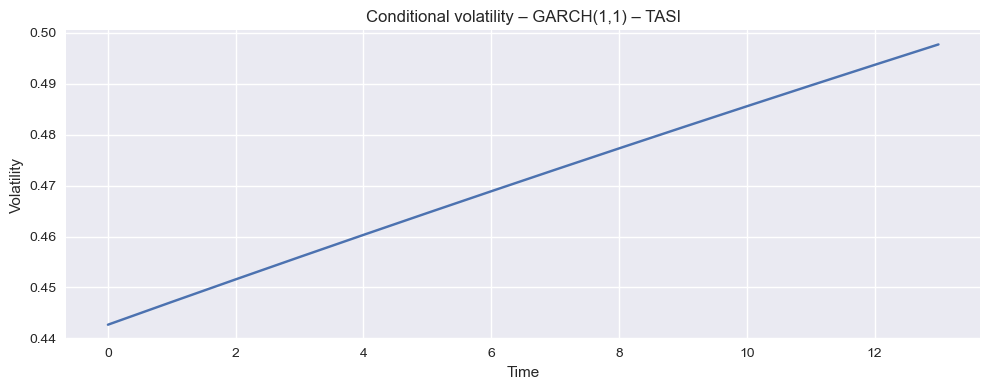

GARCH(1,1) summary – EURO STOXX 50
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              EU_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -14.1102
Distribution:                  Normal   AIC:                           36.2203
Method:            Maximum Likelihood   BIC:                           38.7766
                                        No. Observations:                   14
Date:                Fri, Nov 14 2025   Df Residuals:                       13
Time:                        12:21:16   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.3490      0.

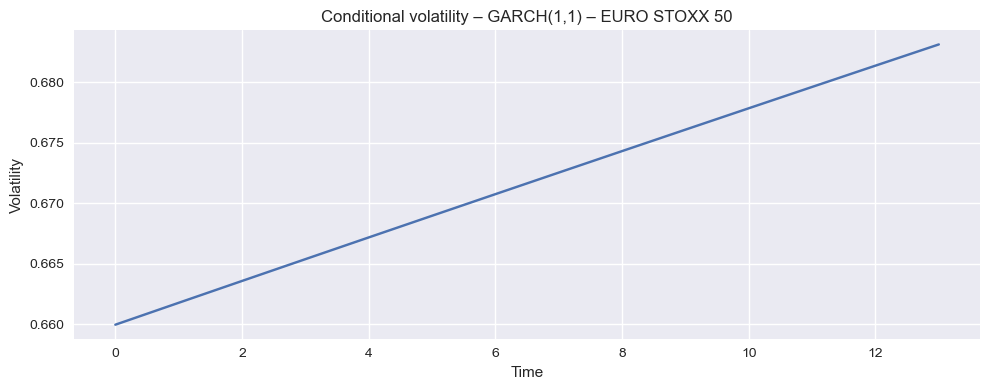

Stress-test scenario results (model-based predicted daily return)


,Scenario,Portfolio,VIX shock,Brent shock,Predicted daily return
0,Moderate risk-off,TASI,0.10,-0.05,-0.001107
1,Moderate risk-off,EURO_STOXX_50,0.10,-0.05,0.007978
2,Severe crisis,TASI,0.30,-0.15,-0.005415
3,Severe crisis,EURO_STOXX_50,0.30,-0.15,0.016744
4,Oil supply shock,TASI,0.05,0.20,0.010038
5,Oil supply shock,EURO_STOXX_50,0.05,0.20,-0.028015


Final comparison – Middle East vs Europe (risk & sensitivity metrics)


,Portfolio,Mean daily return,Volatility (daily std),Sharpe ratio (annual),Max drawdown,VaR 5% (daily),ES 5% (daily),Beta vs VIX,R² (beta regression),R² (VIX+Brent regression)
0,TASI,0.001065,0.004700,3.597821,-0.012387,-0.005529,-0.008480,-0.003024,0.003289,0.032731
1,EURO_STOXX_50,0.003475,0.006883,8.015003,-0.008374,-0.005712,-0.008374,-0.018349,0.056451,0.211225


In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import summary_table

plt.style.use("seaborn-v0_8")

# ============================================================
# 0. Helper: ensure clean daily returns for all series
# ============================================================

def find_price_column(df, candidates):
    """Return the first column name in `candidates` that exists in df.columns."""
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError(f"No price column found among {candidates} in {df.columns.tolist()}")

def compute_simple_return(df, price_candidates, ret_name):
    """
    Make sure a simple daily return column exists.
    If `ret_name` already exists, it is reused.
    """
    if ret_name in df.columns:
        return df

    price_col = find_price_column(df, price_candidates)
    df = df.copy()
    df[ret_name] = df[price_col].pct_change()
    return df

# --- Ensure returns exist for both portfolios and external factors ---

df_tasi = compute_simple_return(
    df_tasi,
    price_candidates=["TASI_Price", "Price"],
    ret_name="TASI_Return"
)

df_eu = compute_simple_return(
    df_eu,
    price_candidates=["EU_Price", "Price"],
    ret_name="EU_Return"
)

vix_df = compute_simple_return(
    vix_df,
    price_candidates=["VIX_Price", "Price"],
    ret_name="VIX_Return"
)

brent_df = compute_simple_return(
    brent_df,
    price_candidates=["Brent_Price", "Price"],
    ret_name="Brent_Return"
)

# Make sure Date is datetime and sorted
for df in [df_tasi, df_eu, vix_df, brent_df]:
    df["Date"] = pd.to_datetime(df["Date"])
    df.sort_values("Date", inplace=True)


# ============================================================
# 1. Align everything on a common date index
# ============================================================

merged_risk = (
    df_tasi[["Date", "TASI_Return"]]
    .merge(df_eu[["Date", "EU_Return"]], on="Date", how="inner")
    .merge(vix_df[["Date", "VIX_Return"]], on="Date", how="inner")
    .merge(brent_df[["Date", "Brent_Return"]], on="Date", how="inner")
    .dropna()
    .reset_index(drop=True)
)

print("Merged risk dataset shape:", merged_risk.shape)
display(merged_risk.head())


# ============================================================
# 2. Risk metrics: Sharpe, Max Drawdown, VaR, ES
# ============================================================

def sharpe_ratio(returns, risk_free=0.0, periods_per_year=252):
    """Annualised Sharpe ratio based on simple returns."""
    excess = returns - risk_free / periods_per_year
    mu = excess.mean()
    sigma = excess.std()
    if sigma == 0:
        return np.nan
    return np.sqrt(periods_per_year) * mu / sigma

def max_drawdown(returns):
    """Maximum drawdown of a return series (in percentage terms)."""
    # Cumulative wealth from 1
    wealth = (1 + returns).cumprod()
    running_max = wealth.cummax()
    drawdown = (wealth - running_max) / running_max
    return drawdown.min()  # negative number

def historical_var_es(returns, alpha=0.05):
    """
    Historical VaR and Expected Shortfall (ES) for a given confidence level.
    VaR is the alpha-quantile of returns,
    ES is the mean of returns below that VaR.
    """
    clean = returns.dropna()
    if len(clean) == 0:
        return np.nan, np.nan
    var = np.quantile(clean, alpha)
    es = clean[clean <= var].mean()
    return var, es

# Compute metrics for both portfolios
metrics = []

for name, col in [("TASI", "TASI_Return"), ("EURO_STOXX_50", "EU_Return")]:
    r = merged_risk[col]

    sr = sharpe_ratio(r)
    mdd = max_drawdown(r)
    var5, es5 = historical_var_es(r, alpha=0.05)

    metrics.append({
        "Portfolio": name,
        "Mean daily return": r.mean(),
        "Volatility (daily std)": r.std(),
        "Sharpe ratio (annual)": sr,
        "Max drawdown": mdd,
        "VaR 5% (daily)": var5,
        "ES 5% (daily)": es5,
    })

risk_table = pd.DataFrame(metrics)
print("Risk metrics comparison")
display(risk_table)


# ============================================================
# 3. Beta vs VIX (market volatility)
#    and econometric regression vs VIX & Brent
# ============================================================

results_beta = []
results_reg = []

for name, col in [("TASI", "TASI_Return"), ("EURO_STOXX_50", "EU_Return")]:
    y = merged_risk[col]
    x_vix = merged_risk["VIX_Return"]  # can be used directly

    # ---------- Beta vs VIX ----------
    X_beta = add_constant(x_vix)
    model_beta = OLS(y, X_beta).fit()
    beta_vix = model_beta.params.get("VIX_Return", np.nan)

    results_beta.append({
        "Portfolio": name,
        "Beta vs VIX": beta_vix,
        "R² (beta regression)": model_beta.rsquared
    })

    # ---------- Multiple regression: returns ~ VIX + Brent ----------
    X_reg = add_constant(merged_risk[["VIX_Return", "Brent_Return"]])
    model_reg = OLS(y, X_reg).fit()

    results_reg.append({
        "Portfolio": name,
        "coef_const": model_reg.params.get("const", np.nan),
        "coef_VIX":   model_reg.params.get("VIX_Return", np.nan),
        "coef_Brent": model_reg.params.get("Brent_Return", np.nan),
        "R² (VIX+Brent regression)": model_reg.rsquared
    })

beta_table = pd.DataFrame(results_beta)
reg_table = pd.DataFrame(results_reg)

print("Beta vs VIX")
display(beta_table)

print("Regression vs VIX and Brent")
display(reg_table)


# ============================================================
# 4. Optional: simple GARCH(1,1) volatility model (if arch is installed)
# ============================================================

try:
    from arch import arch_model

    def fit_garch_11(returns, portfolio_name):
        """
        Fit a simple GARCH(1,1) model to daily returns.
        Returns the fitted model and a small summary dict.
        """
        clean = returns.dropna() * 100  # often work in % for GARCH
        am = arch_model(clean, vol="Garch", p=1, o=0, q=1, dist="normal")
        res = am.fit(disp="off")

        print(f"GARCH(1,1) summary – {portfolio_name}")
        print(res.summary())

        # Plot conditional volatility
        plt.figure(figsize=(10, 4))
        res.conditional_volatility.plot()
        plt.title(f"Conditional volatility – GARCH(1,1) – {portfolio_name}")
        plt.xlabel("Time")
        plt.ylabel("Volatility")
        plt.tight_layout()
        plt.show()

        return res

    garch_tasi = fit_garch_11(merged_risk["TASI_Return"], "TASI")
    garch_eu   = fit_garch_11(merged_risk["EU_Return"], "EURO STOXX 50")

except ImportError:
    print("Package 'arch' is not installed – skipping GARCH modelling.")
    print("You can install it with: pip install arch")


# ============================================================
# 5. Simple stress-test scenarios
# ============================================================

def apply_shock(vix_shock, brent_shock, coef_dict):
    """
    Given a shock on VIX and Brent returns, and regression coefficients,
    compute the predicted portfolio return.
    coef_dict must contain: 'coef_const', 'coef_VIX', 'coef_Brent'.
    """
    return (
        coef_dict["coef_const"]
        + coef_dict["coef_VIX"] * vix_shock
        + coef_dict["coef_Brent"] * brent_shock
    )

# Build a dict of regression coefficients for easy access
coef_map = {row["Portfolio"]: row for _, row in reg_table.iterrows()}

# Example stress scenarios (daily shocks)
scenarios = [
    {"name": "Moderate risk-off", "VIX_shock": 0.10, "Brent_shock": -0.05},   # VIX +10%, oil -5%
    {"name": "Severe crisis",     "VIX_shock": 0.30, "Brent_shock": -0.15},   # VIX +30%, oil -15%
    {"name": "Oil supply shock",  "VIX_shock": 0.05, "Brent_shock": 0.20},    # VIX +5%, oil +20%
]

stress_rows = []
for scen in scenarios:
    for port in ["TASI", "EURO_STOXX_50"]:
        coef = coef_map[port]
        pred_ret = apply_shock(scen["VIX_shock"], scen["Brent_shock"], coef)
        stress_rows.append({
            "Scenario": scen["name"],
            "Portfolio": port,
            "VIX shock": scen["VIX_shock"],
            "Brent shock": scen["Brent_shock"],
            "Predicted daily return": pred_ret
        })

stress_table = pd.DataFrame(stress_rows)
print("Stress-test scenario results (model-based predicted daily return)")
display(stress_table)


# ============================================================
# 6. Final comparison table: TASI vs EURO
# ============================================================

final_comp = (
    risk_table
    .merge(beta_table, on="Portfolio")
    .merge(reg_table[["Portfolio", "R² (VIX+Brent regression)"]], on="Portfolio")
)

print("Final comparison – Middle East vs Europe (risk & sensitivity metrics)")
display(final_comp)
